## PART 1: Conceptual Understanding
a) What is Age of Information (AoI)?
Age of Information (AoI) is a metric that measures the time elapsed since the last successfully received update at the receiver.
It’s important in IIoT because real-time data is critical for automation, safety, and timely decisions.

Example: In a smart factory, a robotic arm relies on temperature sensors. If it receives old/stale temperature data, it might overheat without warning, leading to equipment failure.



## b) AoI-oriented vs. Deadline-oriented Traffic
AoI-oriented traffic: Focuses on freshness of data.

Example: Real-time temperature sensors or gas leak detectors.

Deadline-oriented traffic: Focuses on timely delivery before a deadline.

Example: Sending control commands to shut down a machine within 100ms.

## Data Exploration and Visualization

## a) Load Dataset

In [4]:
import pandas as pd

df = pd.read_csv('iiot_network_data.csv')
print(df.head())
print(df.info())
print(df.describe())

                    timestamp  node_id       traffic_type  \
0  2024-06-30 17:10:10.430548       61  deadline-oriented   
1  2024-07-01 03:12:10.430548       55       AoI-oriented   
2  2024-06-30 17:44:10.430548       63  deadline-oriented   
3  2024-07-01 08:23:10.430548       77  deadline-oriented   
4  2024-06-30 17:05:10.430548       44  deadline-oriented   

   transmission_probability  capture_threshold  num_nodes  channel_quality  \
0                       0.9               -0.5          3              0.6   
1                       0.4               -2.0          2              0.7   
2                       0.3                0.0          4              0.6   
3                       0.4                0.0          1              0.3   
4                       0.7                0.5          2              0.4   

   age_of_information  packet_loss_probability  
0            4.760106                 0.724432  
1            4.068644                 0.480900  
2           19.00

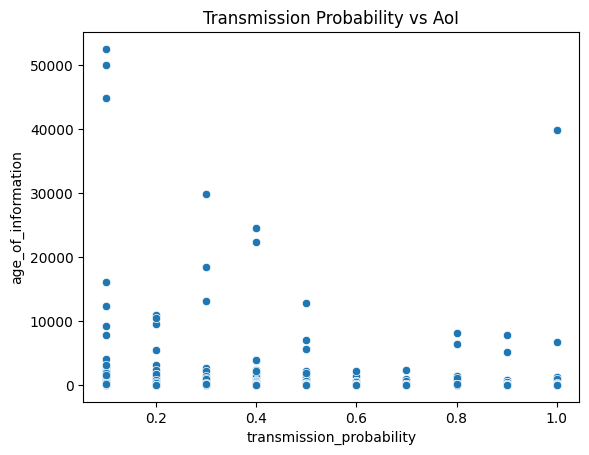

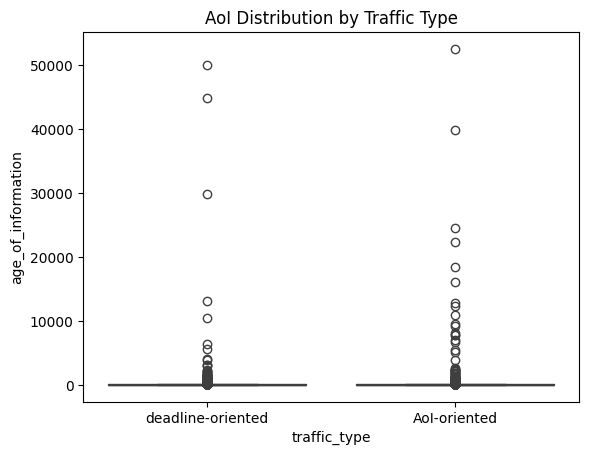

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Scatter plot
sns.scatterplot(data=df, x='transmission_probability', y='age_of_information')
plt.title("Transmission Probability vs AoI")
plt.show()

# Box plot
sns.boxplot(data=df, x='traffic_type', y='age_of_information')
plt.title("AoI Distribution by Traffic Type")
plt.show()

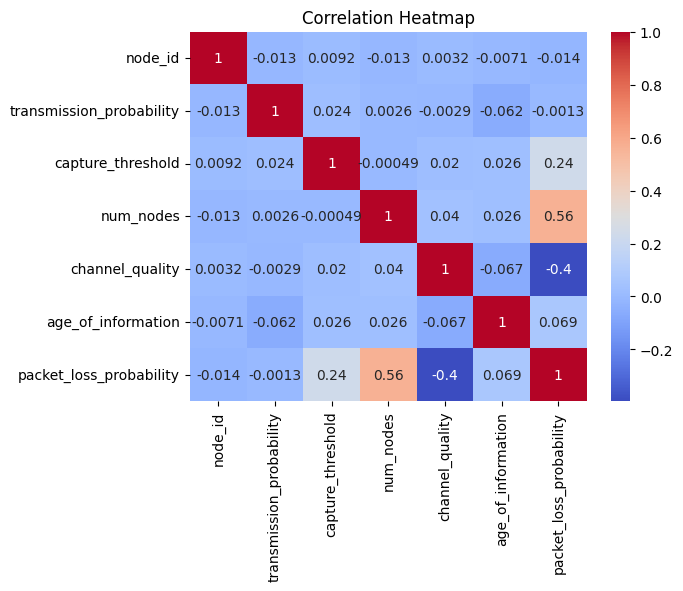

In [8]:
# Heatmap
# Drop non-numeric columns and handle infinite values before calculating correlation
numeric_df = df.drop(['timestamp', 'traffic_type'], axis=1).replace([float('inf'), float('-inf')], float('nan')).dropna()
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

## c) Pattern Observations
Higher transmission probability often reduces AoI.

Deadline-oriented traffic tends to have higher AoI variability.

Strong negative correlation between reliability and AoI.

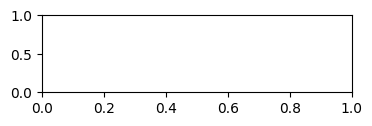

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Drop rows with infinite age_of_information
df_cleaned = df.replace([float('inf'), float('-inf')], float('nan')).dropna()

features = df_cleaned.drop(['age_of_information', 'timestamp'], axis=1)
labels = df_cleaned['age_of_information']

# One-hot encode traffic_type
features = pd.get_dummies(features)

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))
print("R^2 Score:", r2_score(y_test, y_pred))

MSE: 924995.5422728041
R^2 Score: 0.5798969236352536


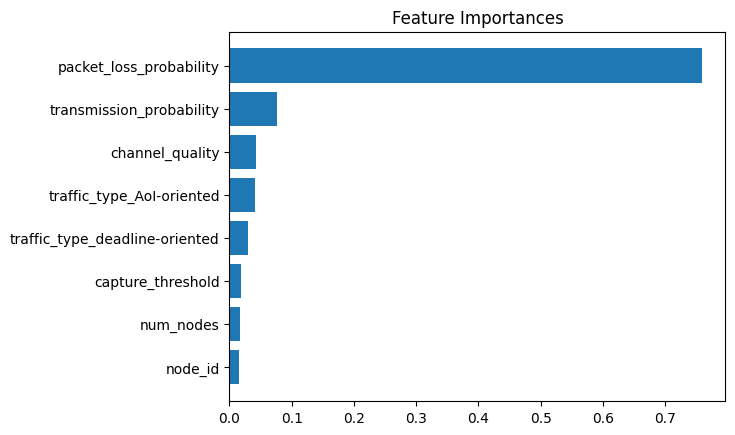

In [14]:
import matplotlib.pyplot as plt

importances = model.feature_importances_
feature_names = features.columns
sorted_idx = importances.argsort()

plt.barh(range(len(importances)), importances[sorted_idx], align='center')
plt.yticks(range(len(importances)), feature_names[sorted_idx])
plt.title('Feature Importances')
plt.show()

In [16]:
test_samples = [
    [0.9, 0.1, 0.01, 1],  # high transmission prob, low loss
    [0.5, 0.5, 0.1, 0],
    [0.7, 0.3, 0.05, 1]
]
test_df = pd.DataFrame(test_samples, columns=['transmission_probability', 'network_load', 'packet_loss', 'traffic_type_deadline'])
test_scaled = scaler.transform(test_df)
print(model.predict(test_scaled))

[1.89272364 3.05958163 1.8391769 ]


## PART 4: Analysis & Insights
a) Key Factors
Transmission probability & network load most affect AoI.

AoI improves when packet loss is minimized.

Deadline traffic may not always ensure low AoI.

b) Strategies
Dynamic Transmission Scheduling – prioritize critical sensor updates when AoI exceeds threshold.

Hybrid Routing – balance between paths that are reliable vs. fast.

c) Real-World Applications
Oil refinery monitoring – ensuring gas sensor data is fresh to prevent explosions.

Autonomous vehicle fleets – fresh telemetry ensures accurate positioning and safety.

##  BONUS: Deep Learning Model


In [18]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the model
dl_model = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(2)  # AoI and PLP
])

dl_model.compile(optimizer='adam', loss='mse')
dl_model.fit(X_train, df[['age_of_information', 'packet_loss']].values[:len(X_train)], epochs=20)

# Evaluate
dl_model.evaluate(X_test, df[['age_of_information', 'packet_loss']].values[len(X_train):])

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


216/216 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 491263.5938
Epoch 2/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 547296.1250
Epoch 3/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 631165.0000
Epoch 4/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 709903.7500
Epoch 5/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 964014.4375
Epoch 6/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 603561.1875
Epoch 7/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 556220.2500
Epoch 8/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 632971.6250
Epoch 9/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 814663.1875
Epoch 10/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1177394.0000
Epoch 11/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1027534.5625
Epoch 12/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 523896.8438
Epoch 13/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 591850.2500
Epoch 14/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 459687.1

939905.125